In [100]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, AggOperations

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split

In [239]:
board_id = BoardIds.CROWN_BOARD.value
params = BrainFlowInputParams()
params.mac_address = "C0:EE:40:84:DD:56"
params.serial_number = "58a99b0107e64cd40ea5e6607882cbe2"
params.board_id = board_id
params.timeout = 5
BoardShim.enable_dev_board_logger()
board = BoardShim(board_id, params)
board.prepare_session()

[2023-01-12 13:19:41.745] [board_logger] [info] incoming json: {
    "board_id": 23,
    "file": "",
    "file_anc": "",
    "file_aux": "",
    "ip_address": "",
    "ip_address_anc": "",
    "ip_address_aux": "",
    "ip_port": 0,
    "ip_port_anc": 0,
    "ip_port_aux": 0,
    "ip_protocol": 0,
    "mac_address": "C0:EE:40:84:DD:56",
    "master_board": -100,
    "other_info": "",
    "serial_number": "58a99b0107e64cd40ea5e6607882cbe2",
    "serial_port": "",
    "timeout": 5
}
[2023-01-12 13:19:41.745] [board_logger] [trace] Board object created 23
[2023-01-12 13:19:41.745] [board_logger] [debug] Use IP port 9000


In [240]:
inputs = []
outputs = []
BoardShim.disable_board_logger()
board.start_stream()
for i in range(1):
    print("Think Nothing")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    nothing = board.get_board_data()[1:9]
    
    print("Think Left")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    left = board.get_board_data()[1:9]

    print("Think Right")
    time.sleep(1)
    board.get_board_data()
    time.sleep(10)
    right = board.get_board_data()[1:9]
    
    inputs.append(nothing)
    inputs.append(left)
    inputs.append(right)
    outputs.append(1)
    outputs.append(0)
    outputs.append(2)
board.stop_stream()

Think Nothing
Think Yes
Think No


In [3]:
dataset = np.array([inputs, outputs], dtype=object)
np.save("raw_data.npy", dataset)

NameError: name 'inputs' is not defined

In [120]:
dataset = np.load("raw_data_5min.npy", allow_pickle=True)

In [121]:
# def downsample(data, hz):
#     num_downsamples = int(math.log2(256 / hz))
#     for i in range(1, num_downsamples + 1):
#         data += np.roll(data, i, axis=2)
#     data = (data / num_downsamples)[:,:,num_downsamples::num_downsamples]
#     return data

# def downsample(data, hz):
#     # HZ should be a full number
#     length = data.shape[1]
#     excess = length % (256 / hz)
    
#     # Cut off excess data
#     if excess != 0:
#         data = data[:,excess:]
#     length = data.shape[1]
    
#     length = data.shape[1]
#     split = np.split(data, length // hz, axis=1)
#     data = np.array([np.mean(section) for section in split]).flatten()
#     return data

def downsample(data, hz, channels=False):
    if channels:
        original_type = data.dtype
        data = data.astype('float64')
        
        downsampled_data = np.empty((data.shape[0], int(256 / hz)))
        for i, channel in enumerate(data):
            downsampled_data[i] = DataFilter.perform_downsampling(channel, int(256 / hz), AggOperations.MEAN.value)
        
        return downsampled_data.astype(original_type)
    
    original_type = data.dtype
    data = data.astype('float64')
    return DataFilter.perform_downsampling(data, int(256 / hz), AggOperations.MEAN.value).astype(original_type)

In [122]:
def format_dataset(dataset):
    inputs = []
    targets = []
    for i, data in enumerate(dataset[0]):
        data = np.mean(data, axis=0)
        
        delta = downsample(data, 2)
        theta = downsample(data, 5)
        alpha_low = downsample(data, 8)
        alpha_high = downsample(data, 11)
        beta_low = downsample(data, 15)
        beta_high = downsample(data, 24)
        gamma_low = downsample(data, 35)
        gamma_mid = downsample(data, 45)
        gamma_high = downsample(data, 55)
        
        # Add to inputs and outputs
        for j in range(len(delta)):
            # Raw Samples Passed
            rsp = j * 2
            brain_waves = np.array([delta[j], theta[rsp//5], alpha_low[rsp//8], alpha_high[rsp//11], beta_low[rsp//15], beta_high[rsp//24], gamma_low[rsp//35], gamma_mid[rsp//45], gamma_high[rsp//55]]).flatten()
            
            inputs.append(brain_waves)
            targets.append(dataset[1][i])

    targets = np.array(targets)
    inputs = np.array(inputs)
    
    return inputs, targets

In [123]:
inputs, targets = format_dataset(dataset)
print(inputs.shape)
print(targets.shape)

(518, 9)
(518,)


In [129]:
inputs_train, inputs_valid, targets_train, targets_valid = train_test_split(inputs, targets, test_size=0.3, random_state=42)
test_dataset = np.load("raw_data_test.npy", allow_pickle=True)
inputs_test, targets_test = format_dataset(test_dataset)

inputs_train = inputs_train.reshape(inputs_train.shape[0], -1)
inputs_valid = inputs_valid.reshape(inputs_valid.shape[0], -1)

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

model = DecisionTreeClassifier(random_state=42)
model = model.fit(inputs_train, targets_train)

grid_cv = GridSearchCV(model, param_grid, n_jobs=-1).fit(inputs_train, targets_train)
model = grid_cv

In [125]:
plt.style.use('seaborn-v0_8-white')

Validation Accuracy: 0.9807692307692307
Test Accuracy: 0.3389830508474576


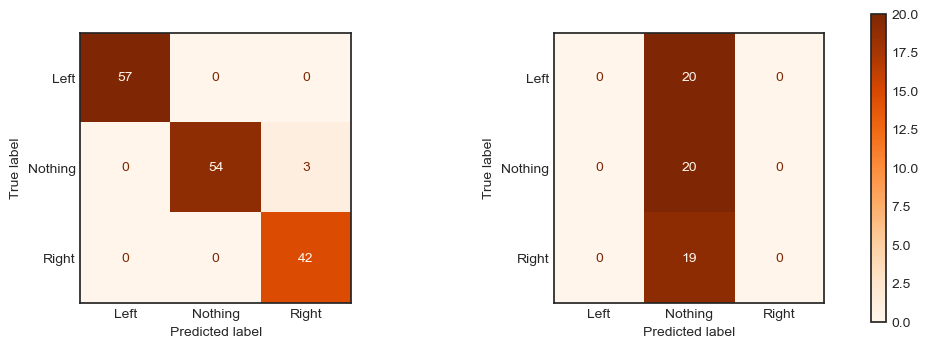

In [136]:
vaccuracy = metrics.accuracy_score(targets_valid, model.predict(inputs_valid))
print(f"Validation Accuracy: {vaccuracy}")

taccuracy = metrics.accuracy_score(targets_test, model.predict(inputs_test))
print(f"Test Accuracy: {taccuracy}")



f, axes = plt.subplots(1, 2)

vcm = metrics.confusion_matrix(targets_valid, model.predict(inputs_valid))
vdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=vcm, display_labels=['Left', 'Nothing', 'Right'])
vdisp.plot(ax=axes[0], cmap=plt.cm.Oranges)
vdisp.im_.colorbar.remove()

plt.subplot(1, 2, 2)
tcm = metrics.confusion_matrix(targets_test, model.predict(inputs_test))
tdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=tcm, display_labels=['Left', 'Nothing', 'Right'])
tdisp.plot(ax=axes[1], cmap=plt.cm.Oranges)
tdisp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.75, hspace=0.1)
f.colorbar(tdisp.im_, ax=axes, shrink=0.5)
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.show()

[Text(0.589041095890411, 0.9545454545454546, 'x[7] <= -5613.43\ngini = 0.666\nsamples = 362\nvalue = [123, 123, 116]'),
 Text(0.3972602739726027, 0.8636363636363636, 'x[7] <= -8274.36\ngini = 0.617\nsamples = 225\nvalue = [55, 54, 116]'),
 Text(0.3424657534246575, 0.7727272727272727, 'gini = 0.0\nsamples = 31\nvalue = [31, 0, 0]'),
 Text(0.4520547945205479, 0.7727272727272727, 'x[4] <= -5438.086\ngini = 0.55\nsamples = 194\nvalue = [24, 54, 116]'),
 Text(0.3972602739726027, 0.6818181818181818, 'x[8] <= -7125.113\ngini = 0.501\nsamples = 182\nvalue = [12, 54, 116]'),
 Text(0.3424657534246575, 0.5909090909090909, 'gini = 0.0\nsamples = 12\nvalue = [12, 0, 0]'),
 Text(0.4520547945205479, 0.5909090909090909, 'x[5] <= -8039.315\ngini = 0.433\nsamples = 170\nvalue = [0, 54, 116]'),
 Text(0.3972602739726027, 0.5, 'gini = 0.0\nsamples = 9\nvalue = [0, 9, 0]'),
 Text(0.5068493150684932, 0.5, 'x[7] <= -6828.999\ngini = 0.403\nsamples = 161\nvalue = [0, 45, 116]'),
 Text(0.3561643835616438, 0.409

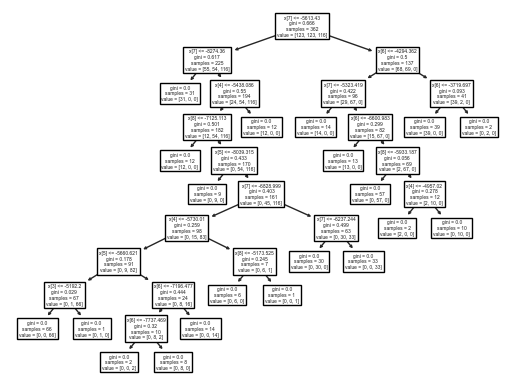

In [127]:
plot_tree(model)

In [261]:
board.stop_stream()

In [ ]:
board.start_stream()
BoardShim.disable_board_logger()

sample_size = 512
start_time = time.time()
last_read = start_time
time.sleep(3)

realtime_raw_data = board.get_board_data()[1:9]

while start_time + 30 > time.time():
    realtime_raw_data = np.concatenate((realtime_raw_data, board.get_board_data()[1:9]), axis=1)[:,-sample_size:]
    
    realtime_data = np.mean(realtime_raw_data, axis=0)
    
    sr = 256
    
    delta = downsample(realtime_data, 2)[-1]
    theta = downsample(realtime_data, 5)[-1]
    alpha_low = downsample(realtime_data, 8)[-1]
    alpha_high = downsample(realtime_data, 11)[-1]
    beta_low = downsample(realtime_data, 15)[-1]
    beta_high = downsample(realtime_data, 24)[-1]
    gamma_low = downsample(realtime_data, 35)[-1]
    gamma_mid = downsample(realtime_data, 45)[-1]
    gamma_high = downsample(realtime_data, 55)[-1]
    
    
    if time.time() > last_read + 0.5:
        predictions = model.predict(np.array([delta, theta, alpha_low, alpha_high, beta_low, beta_high, gamma_low, gamma_mid, gamma_high]).reshape(1, -1))
        last_read = time.time()
        print(['Left', 'Nothing', 'Right'][predictions[0]])
    
    time.sleep(0.1)

board.stop_stream()

In [237]:
board.release_session()